In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix
from wordcloud import WordCloud
from collections import defaultdict

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
initial_df = pd.read_excel("Dataset.xlsx", index_col=None, usecols="A:B")
initial_df

,Column1.data.text,Emotion
0,@RouleLaCookie @luXemusicBX @toda_pisteur Non ...,Dégoût
1,@YarrV @m_nguea Oui cest quand même un gros ra...,Dégoût
2,@salzermorrayOFF @OMjee972 @Diamarc10 @LordDos...,Colère
3,Booba il parle que du père de Vald mais on s'e...,Colère
4,@RGang972 Oui bon sachons raison garder quand ...,INCONNU
...,...,...
964,Finito booba c’est très grave https://t.co/APC...,Dégoût
965,@lilcamscar @nolabuche @vald_ld ça c’est vous ...,Joie
966,@RapAtlas_ Si Booba ne change pas de trottoir,INCONNU
967,Au moins il es premier lui… https://t.co/KZku8...,INCONNU


<AxesSubplot:xlabel='Emotion', ylabel='count'>

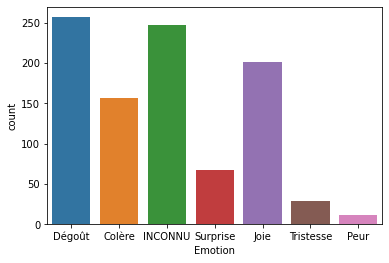

In [4]:
sns.countplot(x=initial_df.Emotion)

In [30]:
cleaned_df = initial_df.replace(to_replace="(@\w+)|(http[a-zA-Z\:\/\.]+)", value ="", regex=True)
# Remove "peur" because the sample size is too small
cleaned_df = cleaned_df.replace(to_replace="Peur", value = "INCONNU")
def custom_encoder(df):
    df = df.replace(to_replace ="Surprise", value =6)
    df = df.replace(to_replace ="Joie", value =5)
    df = df.replace(to_replace ="Dégoût", value =4)
    df = df.replace(to_replace ="Peur", value =3)
    df = df.replace(to_replace ="Colère", value =2)
    df = df.replace(to_replace ="Tristesse", value =1)
    df = df.replace(to_replace ="INCONNU", value =0)
    return df
cleaned_df = custom_encoder(cleaned_df)

In [6]:
lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('french'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [7]:
corpus = text_transformation(cleaned_df['Column1.data.text'])
corpus[0]

'non booba affiche tr bonne chose ca vise suceurs vald defendent malgre daron racelard'

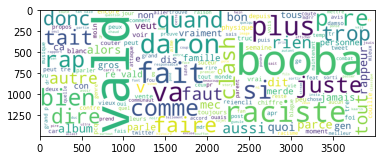

In [8]:
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 4000, height = 1500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)
plt.savefig("wordcloud.svg")

In [35]:
# To tune
cv = CountVectorizer(ngram_range=(1,6))
traindata = cv.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(traindata, cleaned_df['Emotion'],  test_size=0.3, random_state=1)
traindata

<969x33305 sparse matrix of type '<class 'numpy.int64'>'
	with 41019 stored elements in Compressed Sparse Row format>

In [36]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000, 1500],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}

In [37]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=2,return_train_score=True,n_jobs=-1)

In [38]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, None],
                         'max_features': ('auto', 'sqrt'),
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [500, 1000, 1500]},
             return_train_score=True)

In [39]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [40]:
#Check on 100-entries sample
for i in range(100):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  0.26991150442477874
Rank:  248
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Mean Test Score:  0.2713864306784661
Rank:  219
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1500}
Mean Test Score:  0.2713864306784661
Rank:  219
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Mean Test Score:  0.26991150442477874
Rank:  248
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Mean Test Score:  0.26991150442477874
Rank:  248
Parameters:  {'bootstrap': True, 'max_depth': 5

In [41]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=1000)

In [42]:
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

In [47]:
X_test

<291x33305 sparse matrix of type '<class 'numpy.int64'>'
	with 11520 stored elements in Compressed Sparse Row format>